# Life Expectancy - Regression Analysis
Having recently completed a machine learning course at school, I wanted to apply some of the techniques I learnt to my own project. The topic of public health and diseases have always interested me, so I decided to put my skills to the test using [life expectancy data](https://www.kaggle.com/kumarajarshi/life-expectancy-who) from kaggle.

## The Goals:
* Predict life expectancy of countries based off various factors such as GDP, schooling, infection rates etc
* Compare the accuracy of different models using metrics like R2 scores

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets,linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
%matplotlib inline
sns.set()
plt.rcParams["figure.figsize"] = (8, 6)

# Understanding the data
Before attempting to build any models, lets first explore some of the data to get a grasp of the variables we are dealing with. Looking through the table below, we can get a good idea of how the data is structured.

In [2]:
df = pd.read_csv('life_expectancy_data.csv')
df.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


Our main variable of interest is 'Life expectancy', so lets get an idea of how these values are distributed.

Mean: 69.22493169398908
Skewness: -0.6386047358773552


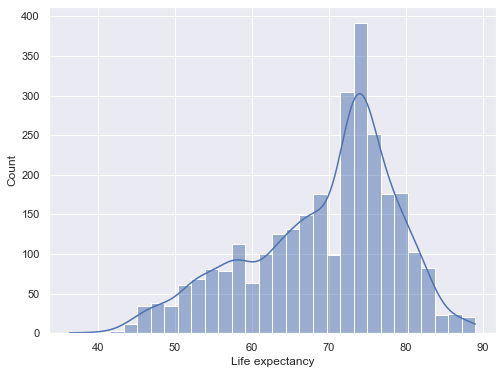

In [4]:
target = df['Life expectancy']
sns.histplot(target, kde=True)
# plt.gcf().set_size_inches(8, 6)
print(f'Mean: {target.mean()}')
print(f'Skewness: {target.skew()}')

We can also get a heatmap which shows us the strength of correlations between pairs of variables.

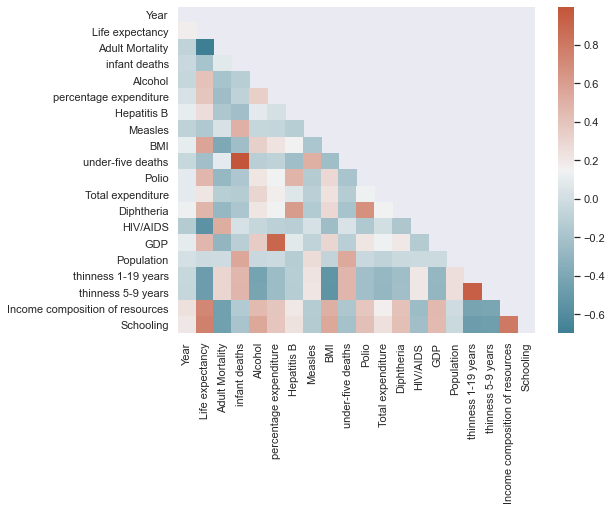

In [5]:
corr = df.corr()

# Creating mask
mask = np.triu(np.ones(corr.shape)).astype(bool)

# Generating colour map object
cmap = sns.diverging_palette(220, 20, as_cmap=True)

hmap = sns.heatmap(corr, mask=mask, cmap=cmap)
# plt.gcf().set_size_inches(8, 6)

Using the map, we can now gauge the strength of certain correlations much more easily. It appears that some pairings have quite strong correlations, but thats definitely a result of having very similar definitions:
* Under five deaths vs infant deaths
* Adult mortality vs life expectancy
* Thinness vs BMI

On the other hand, it seems some of these have almost no correlation:
* BMI vs Hepatitis B
* Diphtheria vs Total expenditure

There are a few however, which aren't as intuitive but their correlations may actually be useful:
* Schooling vs life expectancy
* HIV/AIDS vs life expectancy

Lets visualise some of pairings. Below are four plots, from these we can see that the top two plots have a much clearer correlation than the bottom two.

<AxesSubplot:xlabel='Diphtheria', ylabel='Total expenditure'>

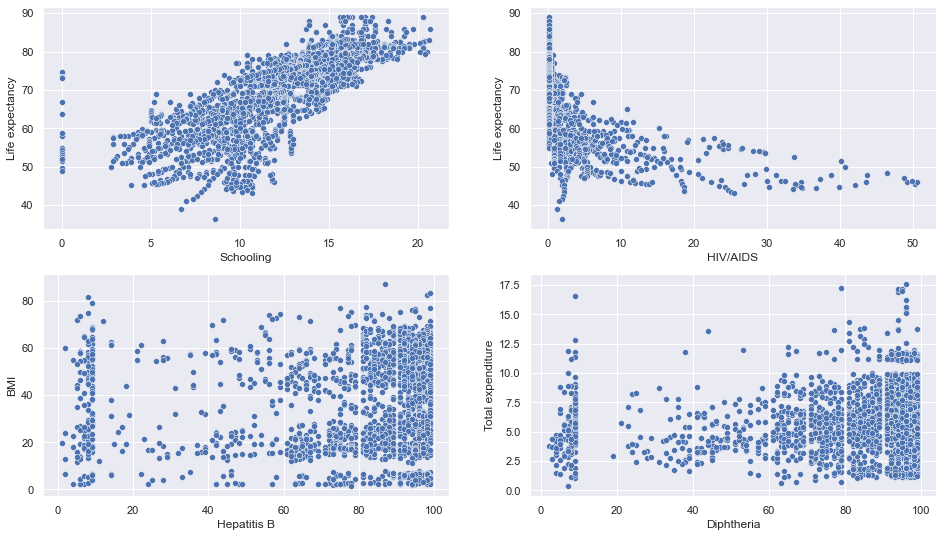

In [6]:
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(16, 9)
sns.scatterplot(x='Schooling', y='Life expectancy', data=df, ax=axs[0, 0])
sns.scatterplot(x='HIV/AIDS', y='Life expectancy', data=df, ax=axs[0, 1])
sns.scatterplot(x='Hepatitis B', y='BMI', data=df, ax=axs[1, 0])
sns.scatterplot(x='Diphtheria', y='Total expenditure', data=df, ax=axs[1, 1])

Now that we have a good understanding of what the data looks like, we can move on to the next section!

# Feature Engineering

## Categorical Data

The country and status variables are categorical (i.e. strings) and so are not acceptable types to fit the model with. To work around this, we are going to use one hot encoding.

In [7]:
cat_df = pd.get_dummies(df[['Country', 'Status']])
num_df = df.drop(columns=['Country', 'Status'])
new_df = pd.concat([num_df, cat_df], axis=1)
cat_df

,Country_Afghanistan,Country_Albania,Country_Algeria,Country_Angola,Country_Antigua and Barbuda,Country_Argentina,Country_Armenia,Country_Australia,Country_Austria,Country_Azerbaijan,...,Country_Uruguay,Country_Uzbekistan,Country_Vanuatu,Country_Venezuela (Bolivarian Republic of),Country_Viet Nam,Country_Yemen,Country_Zambia,Country_Zimbabwe,Status_Developed,Status_Developing
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2933,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
2934,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
2935,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
2936,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1


## Training and Test Data

In [8]:
x_data = new_df.drop(['Life expectancy'], axis=1)
y_data = new_df['Life expectancy']
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2)

## Missing Values

Below we can see a quick summary of the number of null entries. In total there are 2938 rows of data, however not all of these columns have that many entries. For example, 'Population' (column \#17) has only 2286 entries, a significantly less amount.

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   infant deaths                    2938 non-null   int64  
 6   Alcohol                          2744 non-null   float64
 7   percentage expenditure           2938 non-null   float64
 8   Hepatitis B                      2385 non-null   float64
 9   Measles                          2938 non-null   int64  
 10  BMI                              2904 non-null   float64
 11  under-five deaths                2938 non-null   int64  
 12  Polio               

We can view this information in a clearer format:

In [10]:
null_df = pd.DataFrame({'Missing values': df.isnull().sum()})
null_df

,Missing values
Country,0
Year,0
Status,0
Life expectancy,10
Adult Mortality,10
infant deaths,0
Alcohol,194
percentage expenditure,0
Hepatitis B,553
Measles,0


## Imputation

To deal with these missing values, we are going to fill them in with the mean value for its category.

In [11]:
mean_df = pd.DataFrame(data={'Mean training values': x_train.mean(), 'Mean test values': x_test.mean()},
                      index=df.columns)
mean_df.at['Life expectancy', 'Mean training values'] = y_train.mean()
mean_df.at['Life expectancy', 'Mean test values'] = y_test.mean()
mean_df.iloc[:22, :]

,Mean training values,Mean test values
Country,NaN,NaN
Year,2.007594e+03,2.007219e+03
Status,NaN,NaN
Life expectancy,6.930909e+01,6.888716e+01
Adult Mortality,1.635452e+02,1.698185e+02
infant deaths,2.883277e+01,3.618367e+01
Alcohol,4.555173e+00,4.793960e+00
percentage expenditure,7.436196e+02,7.167963e+02
Hepatitis B,8.111623e+01,8.023368e+01
Measles,2.392264e+03,2.528811e+03


To ensure a clear division between the training and test sets, its better to apply this process to each individually. After we do this, we should have no missing values anymore.

In [12]:
x_train = x_train.fillna(x_train.mean())
y_train = y_train.fillna(y_train.mean())
x_test = x_test.fillna(x_test.mean())
y_test = y_test.fillna(y_test.mean())

# Building and Training the Models

Its now time to build some models. The main models that will be used here are:
* Linear Regression
* Ridge Regression
* Lasso Regression
* GET MORE MODELS

Once trained, we can assess the accuracy of our model predictions using MSE and R2 scores.

## Linear Regression

In [13]:
lin_reg = linear_model.LinearRegression()
lin_reg.fit(x_train, y_train)
lin_pred = lin_reg.predict(x_test)
lin_mse = mean_squared_error(lin_pred, y_test)
lin_r2 = r2_score(lin_pred, y_test)

## Ridge Regression

In [14]:
ridge_reg = linear_model.Ridge(alpha=0.001, normalize=True)
ridge_reg.fit(x_train, y_train)
ridge_pred = ridge_reg.predict(x_test)
ridge_mse = mean_squared_error(ridge_pred, y_test)
ridge_r2 = r2_score(ridge_pred, y_test)

## Lasso Regression

In [15]:
lasso_reg = linear_model.Lasso(alpha=0.0001, normalize=True)
lasso_reg.fit(x_train, y_train)
lasso_pred = lasso_reg.predict(x_test)
lasso_mse = mean_squared_error(lasso_pred, y_test)
lasso_r2 = r2_score(lasso_pred, y_test)

# Comparing Models

Below we can see that the models were quite successful, with a R2 score of ~94% and a relatively low mse.

In [16]:
compare_df = pd.DataFrame({'Model': ['Linear', 'Ridge', 'Lasso'], 'Mean squared error': [lin_mse, ridge_mse, lasso_mse], 
                           'R2 score': [lin_r2, ridge_r2, lasso_r2]})
compare_df

,Model,Mean squared error,R2 score
0,Linear,3.561728,0.960152
1,Ridge,3.614235,0.959471
2,Lasso,3.749107,0.957678


# Understanding the Results

At this point we are pretty much done. Our models can predict life expectancy of countries quite accurately, but lets see which variables in particular are impacting this model the most. We'll use the linear regression model to extract the coefficients of each variable.

In [17]:
coef_df = pd.DataFrame(data={'Variable': x_train.columns, 'Coefficient': lin_reg.coef_})
coef_df.head()

,Variable,Coefficient
0,Year,0.271379
1,Adult Mortality,-0.002080
2,infant deaths,0.087517
3,Alcohol,-0.077218
4,percentage expenditure,0.000143


In [18]:
coef_df[abs(coef_df['Coefficient']) > 12]

,Variable,Coefficient
22,Country_Angola,-16.279835
49,Country_Canada,13.106383
50,Country_Central African Republic,-15.435442
51,Country_Chad,-14.191852
63,Country_Côte d'Ivoire,-15.192584
78,Country_Finland,12.481924
79,Country_France,13.601438
85,Country_Greece,13.334870
100,Country_Israel,12.967397
156,Country_Republic of Korea,12.886080


It appears the country itself gives away a lot of information when it comes to determining life expectancy. If instead, we look at the variables with coefficients close to 0, we get some interesting results. The 'Adult Mortality' variable for example, seems to have a very weak weight. However, recalling the correlation heatmap from earlier, it seemed to have a moderate inverse correlation.

In [19]:
coef_df[abs(coef_df['Coefficient']) < 0.01]

,Variable,Coefficient
1,Adult Mortality,-2.079789e-03
4,percentage expenditure,1.428694e-04
5,Hepatitis B,-3.841630e-03
6,Measles,-7.408047e-06
7,BMI,-3.583895e-03
9,Polio,5.064693e-03
11,Diphtheria,7.026497e-03
13,GDP,-1.832770e-05
14,Population,-1.112831e-09
15,thinness 1-19 years,-2.229060e-03
